In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyiron_workflow import Workflow
from pyiron_base import Project

/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-19 17:16:08,924 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/menon/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().
2024-02-19 17:16:08,924 - pyiron_log - WARNING - pyiron found a 'temp

In [17]:
@Workflow.wrap_as.function_node()
def read_input(filename, area):
    """
    My custom function to read an input file and process it
    """
    df = pd.read_csv(filename, delimiter=";", header=[0,1], decimal=',')
    df['Stress'] = df['Load']*1000/area
    load = df['Load']*1000
    strain = df['Extensometer elongation'].values.flatten()
    stress = df['Stress'].values.flatten()
    return stress, strain

In [18]:
@Workflow.wrap_as.function_node()
def calculate_youngs_modulus(stress, strain, strain_cutoff=0.2):
    arg = np.argsort(np.abs(np.array(strain)-strain_cutoff))[0]
    fit = np.polyfit(strain[:arg], stress[:arg], 1)
    youngs_modulus = fit[0]*(1/0.01)/1000
    return youngs_modulus

In [19]:
@Workflow.wrap_as.function_node()
def plot(stress, strain):
    plt.plot(strain, stress)
    plt.xlabel("Strain [%]");
    plt.ylabel("Stress [MPa]");
    return 1

In [20]:
wf = Workflow("youngs_modulus")
wf.read_input = read_input()

#add keyword args
#black formatter

wf.youngs_modulus = calculate_youngs_modulus(wf.read_input.outputs.stress,
                                            wf.read_input.outputs.strain,
                                            )

wf.plot = plot(wf.read_input.outputs.stress,
                                            wf.read_input.outputs.strain)

{'youngs_modulus__youngs_modulus': 188.4145327564868, 'plot__1': 1}

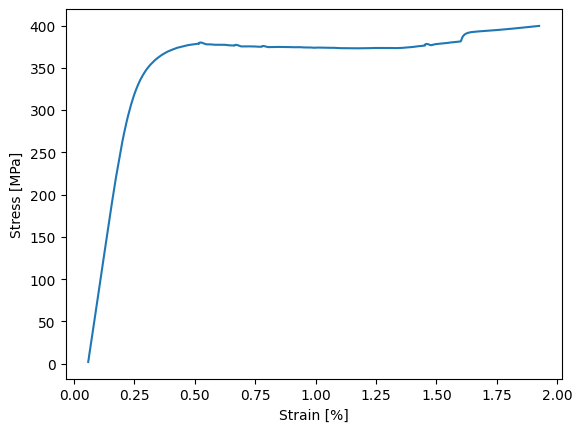

In [6]:
 wf(read_input__filename='dataset_1.csv', read_input__area=120.636)

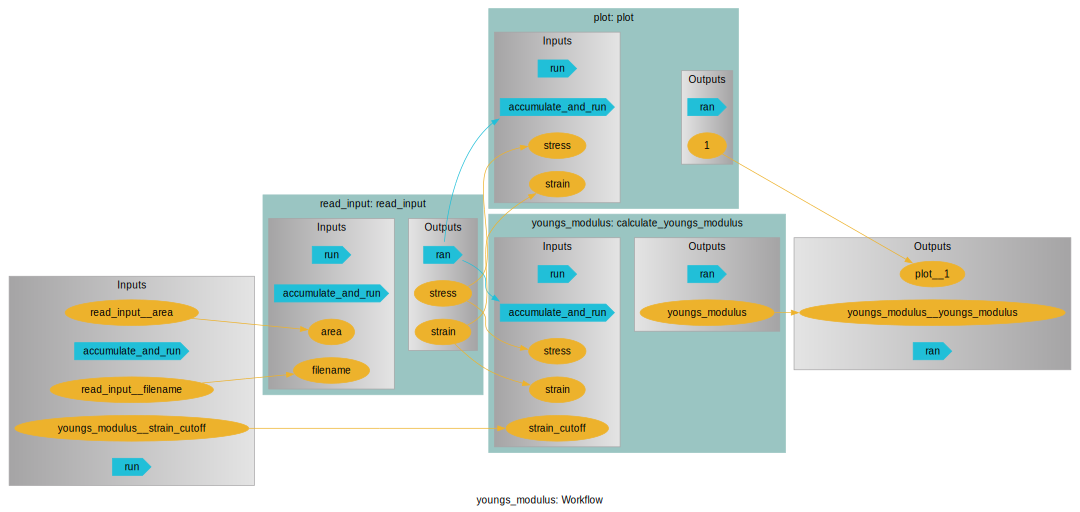

In [9]:
wf.draw(size=(15,20))

In [41]:
@Workflow.wrap_as.macro_node("youngs_modulus")
def YoungsModulus(wf, filename, area, strain_cutoff):
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    wf.read_input = read_input(filename, area)
    wf.youngs_modulus = calculate_youngs_modulus(wf.read_input.outputs.stress,
                                            wf.read_input.outputs.strain,
                                            strain_cutoff)
    return wf.youngs_modulus.outputs.youngs_modulus
    
macro = YoungsModulus()

In [30]:
macro(filename='dataset_1.csv', area=120.636, strain_cutoff=0.2, storage_backend="tinybase")

/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_workflow/node.py:767: UserWarning: The keyword 'storage_backend' was not found among input labels. If you are trying to update a node keyword, please use attribute assignment directly instead of calling
  warnings.warn(


{'youngs_modulus': 188.4145327564868}

In [31]:
macro.save()

/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_workflow/node.py:1282: UserWarning: YoungsModulus is only defined in __main__
  warnings.warn(f"{self.label} is only defined in __main__")
/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_workflow/node.py:1282: UserWarning: read_input is only defined in __main__
  warnings.warn(f"{self.label} is only defined in __main__")
/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_workflow/node.py:1282: UserWarning: youngs_modulus is only defined in __main__
  warnings.warn(f"{self.label} is only defined in __main__")


TypeNotFoundError: YoungsModulus cannot be saved because it (or one of its child nodes) has a type that cannot be imported. Did you dynamically define this node? Try using the node wrapper as a decorator instead. 
Import readiness report: 
YoungsModulus: NOT IMPORTABLE
	filename: ok
	area: ok
	strain_cutoff: ok
	read_input: NOT IMPORTABLE
	youngs_modulus: NOT IMPORTABLE

In [32]:
import pyiron_workflow.job
from pyiron_workflow.job import create_job_with_python_wrapper

In [21]:
pr = Project('fgg')

In [42]:
nj = create_job_with_python_wrapper(pr, macro)

In [43]:
nj.input

DataContainer({'node': <__main__.YoungsModulus object at 0x7fe315783e50>})

In [44]:
nj.run()

The job _run_node06eef8f7f1dc4dd70c6f5d7035c048ac was saved and received the ID: 2225


ReadinessError: YoungsModulus received a run command but is not ready. The node should be neither running nor failed, and all input values should conform to type hints.
YoungsModulus readiness: False
STATE:
running: False
failed: False
INPUTS:
filename ready: False
area ready: False
strain_cutoff ready: False

In [40]:
nj.output.result.outputs.youngs_modulus.value

188.4145327564868

In [45]:
nj.input

DataContainer({'node': <__main__.YoungsModulus object at 0x7fe315783e50>})

In [28]:
for x in np.linspace(0.05, 0.6, 50):
    job = pr.create.job.NodeJob(f'job_{x}')
    job.node = macro(filename='dataset_1.csv', area=120.636, strain_cutoff=x, storage_backend="tinybase")
    job.run()

/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_workflow/node.py:767: UserWarning: The keyword 'storage_backend' was not found among input labels. If you are trying to update a node keyword, please use attribute assignment directly instead of calling
  warnings.warn(
/tmp/ipykernel_8287/3791172250.py:4: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(strain[:arg], stress[:arg], 1)


AttributeError: DotDict object has no attribute '_working_directory'